# Final Machine Learning Pipeline

This will feature an end-to-end ML pipeline

## Reproducibility: Set the seed

Given there is an element of randomness, set the seed

In [1]:
# data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for saving the pipeline
import joblib

# from Scikit-learn
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer

# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
)

from feature_engine.transformation import (
    LogTransformer,
    YeoJohnsonTransformer,
)

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import preprocessors as pp

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

# Load the dataset

In [2]:
# load dataset
data = pd.read_csv('../data/train.csv')

# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Let's separate into train and test set
# Remember to set the seed (random_state for this sklearn function)

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Id', 'SalePrice'], axis=1), # predictive variables
    data['SalePrice'], # target
    test_size=0.1, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

## Target

In [4]:
y_train = np.log(y_train)
y_test = np.log(y_test)

# Config

In [5]:
# categorical variables with NA in train set
CATEGORICAL_VARS_WITH_NA_FREQUENT = [
                                     'BsmtQual',
                                     'BsmtExposure',
                                     'BsmtFinType1',
                                     'GarageFinish',]


CATEGORICAL_VARS_WITH_NA_MISSING = ['FireplaceQu']


# numerical variables with NA in train set
NUMERICAL_VARS_WITH_NA = ['LotFrontage']


TEMPORAL_VARS = ['YearRemodAdd']
REF_VAR = "YrSold"


# variables to log transform
NUMERICALS_LOG_VARS = ["LotFrontage", "1stFlrSF", "GrLivArea"]

NUMERICALS_YEO_VARS = ['LotArea']


BINARIZE_VARS = ['ScreenPorch']

# variables to map
QUAL_VARS = ['ExterQual', 'BsmtQual',
             'HeatingQC', 'KitchenQual', 'FireplaceQu',
             ]

EXPOSURE_VARS = ['BsmtExposure']

FINISH_VARS = ['BsmtFinType1']

GARAGE_VARS = ['GarageFinish']

FENCE_VARS = ['Fence']

# categorical variables to encode
CATEGORICAL_VARS = [
    'MSZoning',
    'LotShape',
    'LandContour',
    'LotConfig',
    'Neighborhood',
    'RoofStyle',
    'Exterior1st',
    'Foundation',
    'CentralAir',
    'Functional',
    'PavedDrive',
    'SaleCondition',
    'MSSubClass']


QUAL_MAPPINGS = {'Po': 1, 'Fa': 2, 'TA': 3,
                 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

EXPOSURE_MAPPINGS = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

FINISH_MAPPINGS = {'Missing': 0, 'NA': 0, 'Unf': 1,
                   'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

GARAGE_MAPPINGS = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

FENCE_MAPPINGS = {'Missing': 0, 'NA': 0,
                  'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}


FEATURES = FEATURES = [
    'MSSubClass',
    'MSZoning',
    'LotFrontage',
    'LotShape',
    'LandContour',
    'LotConfig',
    'Neighborhood',
    'OverallQual',
    'OverallCond',
    'YearRemodAdd',
    'RoofStyle',
    'Exterior1st',
    'ExterQual',
    'Foundation',
    'BsmtQual',
    'BsmtExposure',
    'BsmtFinType1',
    'HeatingQC',
    'CentralAir',
    '1stFlrSF',
    '2ndFlrSF',
    'GrLivArea',
    'BsmtFullBath',
    'HalfBath',
    'KitchenQual',
    'TotRmsAbvGrd',
    'Functional',
    'Fireplaces',
    'FireplaceQu',
    'GarageFinish',
    'GarageCars',
    'GarageArea',
    'PavedDrive',
    'WoodDeckSF',
    'ScreenPorch',
    'SaleCondition',
    # this one is only to calculate temporal variable:
    "YrSold",
]

In [6]:
X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

X_train.shape, X_test.shape

((1314, 37), (146, 37))

# End to End Pipeline

In [7]:
# set up the pipeline
price_pipe = Pipeline([

    # ===== IMPUTATION =====
    # impute categorical variables with string missing
    ('missing_imputation', CategoricalImputer(
        imputation_method='missing', variables=CATEGORICAL_VARS_WITH_NA_MISSING)),

    ('frequent_imputation', CategoricalImputer(
        imputation_method='frequent', variables=CATEGORICAL_VARS_WITH_NA_FREQUENT)),

    # add missing indicator
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)),

    # impute numerical variables with the mean
    ('mean_imputation', MeanMedianImputer(
        imputation_method='mean', variables=NUMERICAL_VARS_WITH_NA
    )),
    
    
    # == TEMPORAL VARIABLES ====
    ('elapsed_time', pp.TemporalVariableTransformer(
        variables=TEMPORAL_VARS, reference_variable=REF_VAR)),

    ('drop_features', DropFeatures(features_to_drop=[REF_VAR])),

   

    # ==== VARIABLE TRANSFORMATION =====
    ('log', LogTransformer(variables=NUMERICALS_LOG_VARS)),
    
#     ('yeojohnson', YeoJohnsonTransformer(variables=NUMERICALS_YEO_VARS)),
    
    ('binarizer', SklearnTransformerWrapper(
        transformer=Binarizer(threshold=0), variables=BINARIZE_VARS)),
    

    # === mappers ===
    ('mapper_qual', pp.Mapper(
        variables=QUAL_VARS, mappings=QUAL_MAPPINGS)),

    ('mapper_exposure', pp.Mapper(
        variables=EXPOSURE_VARS, mappings=EXPOSURE_MAPPINGS)),

    ('mapper_finish', pp.Mapper(
        variables=FINISH_VARS, mappings=FINISH_MAPPINGS)),

    ('mapper_garage', pp.Mapper(
        variables=GARAGE_VARS, mappings=GARAGE_MAPPINGS)),
    
#     ('mapper_fence', pp.Mapper(
#         variables=FENCE_VARS, mappings=FENCE_MAPPINGS)),


    # == CATEGORICAL ENCODING
    ('rare_label_encoder', RareLabelEncoder(
        tol=0.01, n_categories=1, variables=CATEGORICAL_VARS
    )),

    # encode categorical and discrete variables using the target mean
    ('categorical_encoder', OrdinalEncoder(
        encoding_method='ordered', variables=CATEGORICAL_VARS)),
    
    
    ('scaler', MinMaxScaler()),
#     ('selector', SelectFromModel(Lasso(alpha=0.001, random_state=0))),
    ('Lasso', Lasso(alpha=0.001, random_state=0)),
])

In [8]:
X_train[CATEGORICAL_VARS] = X_train[CATEGORICAL_VARS].astype('category')
X_test[CATEGORICAL_VARS] = X_test[CATEGORICAL_VARS].astype('category')

# train the pipeline
price_pipe.fit(X_train, y_train)

Pipeline(steps=[('missing_imputation',
                 CategoricalImputer(variables=['FireplaceQu'])),
                ('frequent_imputation',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['BsmtQual', 'BsmtExposure',
                                               'BsmtFinType1',
                                               'GarageFinish'])),
                ('missing_indicator',
                 AddMissingIndicator(variables=['LotFrontage'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation_method=...
                                             'CentralAir', 'Functional',
                                             'PavedDrive', 'SaleCondition',
                                             'MSSubClass'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['MSZoning', 'LotShape',
                                           'LandContour', 'LotConfig',
                                           'Neighborhood', 'RoofStyle',
                                           'Exterior1st', 'Foundation',
                                           'CentralAir', 'Functional',
                                           'PavedDrive', 'SaleCondition',
                                           'MSSubClass'])),
                ('scaler', MinMaxScaler()),
                ('Lasso', Lasso(alpha=0.001, random_state=0))])

# Evaluate the model

In [9]:
# Make predictions on train set

pred_train = price_pipe.predict(X_train)

# Determine mse, rmse, and r2
print('train mse: {}'.format(mean_squared_error(np.exp(y_train), np.exp(pred_train))))
print('train rmse: {}'.format(np.sqrt(mean_squared_error(np.exp(y_train), np.exp(pred_train)))))
print('train r2: {}'.format(r2_score(np.exp(y_train), np.exp(pred_train))))
print()
# Make predictions on test set

pred_test = price_pipe.predict(X_test)

# Determine mse, rmse, and r2
print('test mse: {}'.format(mean_squared_error(np.exp(y_test), np.exp(pred_test))))
print('test rmse: {}'.format(np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred_test)))))
print('test r2: {}'.format(r2_score(np.exp(y_test), np.exp(pred_test))))
print()
#Average house prices
print('Average house price: ', int(np.exp(y_train).median()))

train mse: 781396630.9031373
train rmse: 27953.472609018318
train r2: 0.8748530315439074

test mse: 1060769014.9333136
test rmse: 32569.44910392734
test r2: 0.8456415571208441

Average house price:  163000


Text(0.5, 1.0, 'Evaluation of Model Predictions')

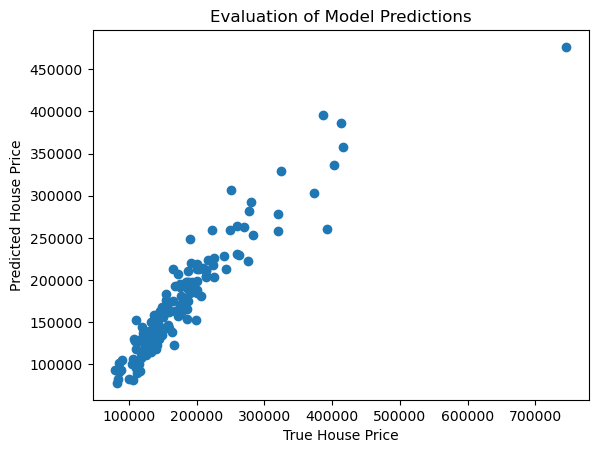

In [10]:
# Evaluation predictions wrt to real sales price

plt.scatter(np.exp(y_test), np.exp(pred_test))
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of Model Predictions')

Text(0.5, 1.0, 'Distribution of Errors')

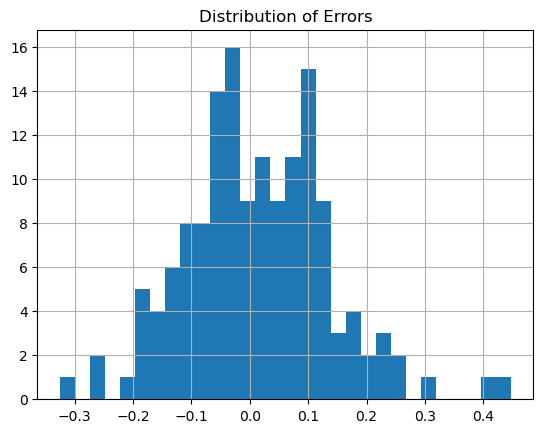

In [11]:
# Evaluate the distribution of the errors

y_test.reset_index(drop=True, inplace=True)

preds =pd.Series(price_pipe.predict(X_test))

errors = y_test - preds
errors.hist(bins=30)
plt.title('Distribution of Errors')


In [12]:
# Save the scaler

joblib.dump(price_pipe, '../models/price_pipe.joblib')

['../models/price_pipe.joblib']

# Time to score new data

In [13]:
data = pd.read_csv('../data/test.csv')

data.drop('Id', axis=1, inplace=True)

data['MSSubClass'] = data['MSSubClass'].astype('category')

data = data[FEATURES]
print(data.shape)

(1459, 37)


In [14]:
# Capture variables that might contain missing data in the test set
new_vars_with_na = [
    var for var in FEATURES
    if var not in CATEGORICAL_VARS_WITH_NA_FREQUENT + CATEGORICAL_VARS_WITH_NA_MISSING + NUMERICAL_VARS_WITH_NA
    and data[var].isnull().sum() > 0]

new_vars_with_na

['MSZoning',
 'Exterior1st',
 'BsmtFullBath',
 'KitchenQual',
 'Functional',
 'GarageCars',
 'GarageArea']

In [15]:
# % of missing values in the test set
data[new_vars_with_na].isnull().mean()


MSZoning        0.002742
Exterior1st     0.000685
BsmtFullBath    0.001371
KitchenQual     0.000685
Functional      0.001371
GarageCars      0.000685
GarageArea      0.000685
dtype: float64

In [16]:
# Dropping for simplicity
data.dropna(subset = new_vars_with_na, inplace=True)

print(data.shape)

(1449, 37)


In [17]:
new_preds = price_pipe.predict(data)

<Axes: >

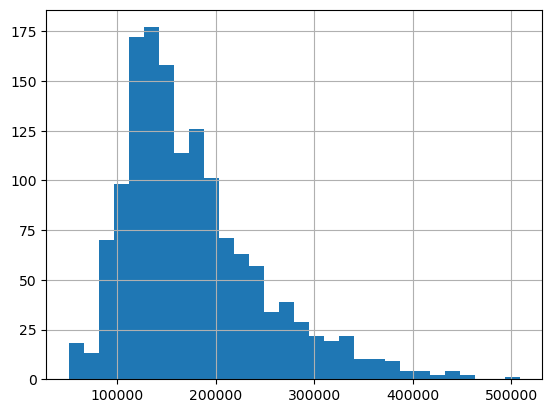

In [18]:
# Let's plot the predicted data
pd.Series(np.exp(new_preds)).hist(bins=30)